In [41]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt


Our SEIRD model plus intensive care

In [42]:
# describe the model
def deriv(y, t, N, beta, gamma, delta, alpha, rho, my, z, daysiniva, ivaprob, ivaproblive):
    S, E, I, R, D, In, Ink, Inm, Dk, Dm, limit = y
    dSdt = -beta(t) * S * I / N + my *  R
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I - z * ivaprob * I
    dRdt = (1 - alpha) * gamma * I - my * R + daysiniva * ivaproblive * In
    dDdt = alpha * rho * I + daysiniva * (1 - ivaproblive) * In
    
    dIndt = z * ivaprob * I - daysiniva * (1 - ivaproblive) * In - daysiniva * ivaproblive * In
    dInkdt = dIndt * w
    dInmdt = dIndt * (1-w)

    dDkdt = dDdt * deadwomen 
    dDmdt = dDdt * (1 - deadwomen)
    
    dlimitdt = 0 # Adding line for limit of intensive care seats
    
    return dSdt, dEdt, dIdt, dRdt, dDdt, dIndt, dInkdt, dInmdt, dDkdt, dDmdt, dlimitdt





 We chose to use relevant data over the spreading of the decease to make a fundamental ond objective model.

We have split Recovered into two different curves, one for persons who have recovered, R and one for people who have died, D.
To do that we used the percent for how many people that have died because of Covid in Sweden which was approximately 2% according to Folkhälsomyndigheten by the time we extracted the data.

We added a group In, intensive care and used the percent 0.01 of all people who have been sick according to Folkhälsomyndigheten
Then we split this group In into two groups, women and men and we used the percent here as well to show the difference.

We took the data for intensive care from this website https://experience.arcgis.com/experience/2dc63e26f509468f896ec69476b0dab3 
The data was downloaded on the 12 of January which might explain any slight differences to current data.


In [43]:
N =  10000000              # Approximately Swedens population    
gamma = 1.0 / 7.0 # A person is sick for approximately 7 days.
rho = 1.0 / 12.0 #dying 9 days after first day sick
delta = 1.0 / 5.0 # Incubation time
alpha = 0.02 # 2% death rate
my = 1.0 / 180.0 # 180 days to become susceptible again
z = 1.0 / 10.7 # rate of days between sickness to intensive care https://www.icuregswe.org/data--resultat/covid-19-i-svensk-intensivvard/
ivaprob = 0.008 # probability of ending up on intensive care
ivaproblive = 0.8 # 80% survival rate on IVA https://lakartidningen.se/aktuellt/nyheter/2020/05/for-tidigt-att-uttala-sig-om-overlevnad-i-intensivvarden/
daysiniva = 1/14 # two weeks

#Percentage:
w=0.288 #28.8 % women in intensive care
deadwomen = 0.46


L1 = 60 # L is differnet timeperiod for different R0
L2 = 80
L3 = 200


def R_0(t):
    if t < L1:
     return 5.0 
    elif L1 < t < L2:
     return 2.0
    elif L2 < t < L3:
     return 1.5
    else:
     return 4.0 #R0 increases again and result in second wave
    
def beta(t):
    return R_0(t) * gamma
# R_0 depends of the time, how many persons one person infects, to se how the spread of the virus looks 
# if the government puts int harder restrictions, a lockdown after L days.


S0, E0, I0, R0, D0, In0, Ink0, Inm0, Dk0, Dm0, limit0 = N-1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 500 # initial conditions: one infected, rest susceptible

In [44]:
t = np.linspace(0, 300, 1000) # Grid of time points (in days)


y0 = S0, E0, I0, R0, D0, In0, Ink0, Inm0, Dk0, Dm0, limit0 # Initial conditions vector

# Integrate the SEIRDIn equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho, my, z, daysiniva, ivaprob, ivaproblive))
S, E, I, R, D, In, Ink, Inm, Dk, Dm, limit = ret.T

In [45]:
def plotseird(t, S, E, I, R, D):
  f, ax = plt.subplots(1,1,figsize=(10,4))
  ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
  ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
  ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
  ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
  ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Deceased')




  ax.set_xlabel('Time (days)')

  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  legend = ax.legend()
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)  
  plt.show();
    


In [46]:
def plotiva(t, In, Ink, Inm, limit):
  f, ax = plt.subplots(1,1,figsize=(10,4))
 
  ax.plot(t, In, 'y', alpha=0.7, linewidth=2, label='Intensive care')
  ax.plot(t, Ink, 'g', alpha=0.7, linewidth=2, label='Intensive care women (28.8%)')
  ax.plot(t, Inm, 'c', alpha=0.7, linewidth=2, label='Intensive care men (71.2%)')
  ax.plot(t, limit, 'k', alpha=0.7, linewidth=2, label='Limit intensive care')
  
  #ax.plot(t, m)


  ax.set_xlabel('Time (days)')

  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  legend = ax.legend()
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
  
  plt.show();

In [47]:
def plotdead(t, dDkdt, dDmdt):
  f, ax = plt.subplots(1,1,figsize=(10,4))

  ax.plot(t, Dk, 'g', alpha=0.7, linewidth=2, label='Death women (46%)')
  ax.plot(t, Dm, 'c', alpha=0.7, linewidth=2, label='Death men (54%)')

  ax.set_xlabel('Time (days)')

  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  legend = ax.legend()
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
  
  plt.show();


plot the graph

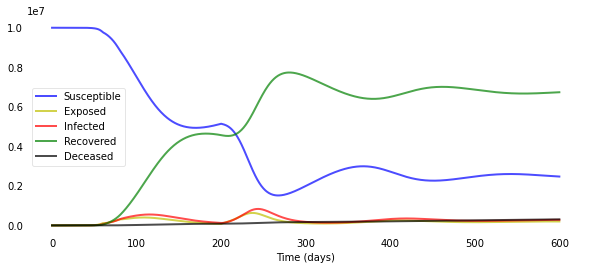

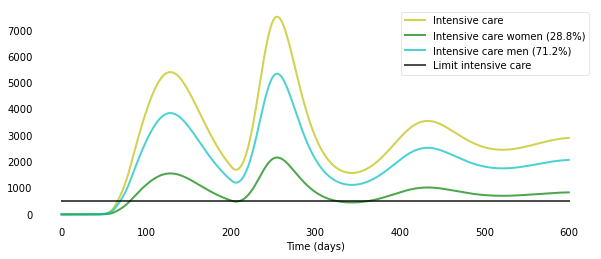

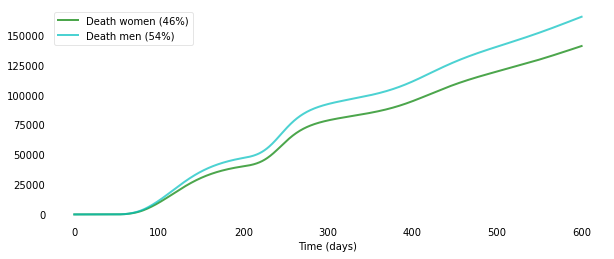

In [48]:

plotseird(t, S, E, I, R, D)
plotiva(t, In, Ink, Inm, limit)
plotdead(t, Dk, Dm)



 When we read about different
 data on Folkhälsomyndigheten we found it intresting that it was a big difference between 
 women and men, 72% men and 28% women, who hade been intensive cared so whe chose to show this in a separate graph. 